In [1]:
!pip install networkx==2.4

In [2]:
!pip install stellargraph

In [3]:
!pip install linkpred==0.5.1

In [4]:
import pandas as pd
import numpy as np
import linkpred
import networkx as nx
import multiprocessing
import matplotlib.pyplot as plt

from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 
from math import isclose
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [5]:
df= pd.read_csv("weight.csv",index_col=0)

In [6]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[1], l[2], weight=int(float(l[3].rstrip('\n'))))
    return g


In [7]:
def sample_data(g): 
    degree_calc = {node: val for (node, val) in g.degree()}
    degree = dict(sorted(degree_calc.items(), key=lambda item: item[1], reverse = True))
    sample = []
    for k, v in degree.items():
        if(v >=  20):
            sample.append(k)   
    sample_data = g.subgraph(sample)
    return sample_data

In [8]:
column_names = df.columns

# Stampare i nomi delle colonne
print("Nomi delle colonne nel DataFrame:")
for column in column_names:
    print(column)

Nomi delle colonne nel DataFrame:
Source
Target
Weight


In [9]:
df.shape
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55847 entries, 0 to 403446
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  55847 non-null  object
 1   Target  55847 non-null  object
 2   Weight  55847 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,Source,Target,Weight
0,HENDERSON BRIAN LESLIE,CUI YAN,28
1,HENDERSON BRIAN LESLIE,DORRIETY DANIEL JAMES,28
2,HENDERSON BRIAN LESLIE,SHUBERT GARY CHARLES,12
3,HENDERSON BRIAN LESLIE,COOK PAUL ALBERT,28
4,CUI YAN,DORRIETY DANIEL JAMES,54
5,CUI YAN,SHUBERT GARY CHARLES,12
6,CUI YAN,COOK PAUL ALBERT,26
7,DORRIETY DANIEL JAMES,SHUBERT GARY CHARLES,12
8,DORRIETY DANIEL JAMES,COOK PAUL ALBERT,26
9,SHUBERT GARY CHARLES,COOK PAUL ALBERT,12


In [10]:
def read_net_w(csv_file):
    g = nx.Graph()

    try:
        df = pd.read_csv(csv_file)

        for node in df['Source']:
            g.add_node(node)

        for _, row in df.iterrows():
            try:
                weight = float(row['Weight'])
            except ValueError:
                # Gestisci l'errore di conversione e assegna un valore predefinito (o None)
                weight = None

            g.add_edge(row['Source'], row['Target'], weight=weight)

    except pd.errors.EmptyDataError:
        # Gestisci il caso in cui il file CSV sia vuoto
        pass
    except FileNotFoundError:
        # Gestisci il caso in cui il file CSV non esista
        pass

    return g

g = read_net_w("weight.csv")

In [11]:
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
g.remove_nodes_from([n for n in g if n not in set(Gcc[0])])

In [12]:
g.remove_edges_from(list(nx.selfloop_edges(g)))

In [13]:
g_small = sample_data(g)

In [14]:
stellar_g = StellarGraph.from_networkx(g_small)

In [15]:
num_nodes = len(g_small.nodes())
num_edges = len(g_small.edges())
print(f"Numero di nodi: {num_nodes}")
print(f"Numero di archi: {num_edges}")

connected_components = list(nx.connected_components(g_small))
print(f"Componenti connesse: {connected_components}")

Numero di nodi: 858
Numero di archi: 3996
Componenti connesse: [{'TAKEUCHI TOSHIFUMI', 'YOSHINAGA KAZUO', 'ALSHINA ELENA', 'SHOJI MAMORU', 'AZUHATA SHIGERU', 'MELTON PATRICK BENEDICT', 'NARAHARA TOSHIKAZU', 'CHAN DAVID SO KEUNG', 'NARAYANAN VIJAY', 'INUI TOSHIHARU', 'YOKONO ATARU', 'KURODA SHINICHI', 'KIM JAE-YOEL', 'LEE HAK-JU', 'STOIA LUCAS JOHN', 'NOBUE TOMOTAKA', 'SHIN CHEOLKYU', 'YONEMITSU JUN', 'SRIVASTAVA ALOK MANI', 'MINEMURA HIROYUKI', 'ABE TSUTOMU', 'ZHANG HUA', 'KIM SUNG-JIN', 'MURAI KEIICHI', 'COMANZO HOLLY ANN', 'SATO MAKOTO', 'KUDO KIYOMITSU', 'MATSUDA HIROMU', 'VAN LIESHOUT GERT-JAN', 'JUNG JUNG-SOO', 'NISHIKAWA AKIO', 'LORRAINE PETER WILLIAM', 'MIYABE SHIGEO', 'VAN DER VELDE HIMKE', 'CHO JOON-YOUNG', 'MISUMI TERUO', 'KIM SANG-BUM', 'TANAKA SHIGEAKI', 'LIU YUNFENG', 'SUZUKI HIDETOSHI', 'MIYAMOTO HARUKAZU', 'LJUNG RICKARD', 'PARK DONG-SEEK', 'HSU LOUIS L', 'MONIZ THOMAS ORY', 'SATO MASAAKI', 'EDA KAZUO', 'KING ROBERT DEAN', 'TANAKA SHINICHI', 'ISOGAI TOKIO', 'TAMURA YASUY

In [16]:
##Unsupervised Link Prediction

In [17]:
cn = linkpred.predictors.CommonNeighbours(g_small, excluded=g_small.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()

top = cn_results.top(20)
for edge, score in top.items():
    print(edge, score)

IZUMIDA MASAAKI - ABE TSUTOMU 24.0
OGATA MASATSUGU - ANJO ICHIRO 20.0
MURAKAMI GEN - ANJO ICHIRO 20.0
EGUCHI SYUUJI - ANJO ICHIRO 20.0
SAIKAWA HIDEO - GOTO AKIRA 19.0
VAN LIESHOUT GERT-JAN - VAN LIESHOUT GERT JAN 18.0
SAITO AKIO - ISHINAGA HIROYUKI 18.0
ISHINAGA HIROYUKI - HATTORI YOSHIFUMI 18.0
TANAKA SHIGEAKI - ABE TSUTOMU 17.0
SUGIMOTO HITOSHI - KUWABARA NOBUYUKI 17.0
SUGAMA SADAYUKI - MASUDA KAZUAKI 17.0
MORIYAMA JIRO - MATSUBARA MIYUKI 17.0
MAEOKA KUNIHIKO - ISHINAGA HIROYUKI 17.0
KAWAI JUN - GOTO AKIRA 17.0
WATANABE TAKASHI - KIMURA MAKIKO 16.0
WATANABE TAKASHI - ABE TSUTOMU 16.0
OHBA TAKASHI - KUWABARA NOBUYUKI 16.0
NAGOSHI SHIGEYASU - KUWABARA NOBUYUKI 16.0
MATSUBARA MIYUKI - KUWABARA NOBUYUKI 16.0
KUWABARA NOBUYUKI - KAWAI JUN 16.0


In [18]:
jc = linkpred.predictors.Jaccard(g_small, excluded=g_small.edges())
jc_results = jc.predict()

top = jc_results.top(20)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 1.0
TOMIZAWA TAKESHI - KONDO SHIGEO 1.0
LANG STEFFEN - DANOV VLADIMIR 1.0
SHIMIZU ISAMU - FUJIOKA YASUSHI 0.8
OGATA MASATSUGU - ANJO ICHIRO 0.8
MURAKAMI GEN - ANJO ICHIRO 0.8
EGUCHI SYUUJI - ANJO ICHIRO 0.8
SAITOH AKIHITO - IWAWAKI HIRONOBU 0.7777777777777778
TOMOSADA MASAHIRO - KANEKO SATOSHI 0.75
SASAKI YOSHIKI - KAWAMURA HIROYUKI 0.75
SEKI SATOSHI - MARU AKIKO 0.7272727272727273
YAGASAKI YOICHI - HATTORI SHINOBU 0.7142857142857143
LEE HYUN-WOO - LEE HYEON-WOO 0.7142857142857143
YEO JEONGHO - JI HYOUNGJU 0.6875
PARK SUNGJIN - JI HYOUNGJU 0.6875
YAMAMOTO KATSUHIKO - UEDA SHIGEKI 0.6666666666666666
VAN LIESHOUT GERT-JAN - VAN LIESHOUT GERT JAN 0.6666666666666666
TSUDA SHINICHIRO - MORIOKA YUICHI 0.6666666666666666
IMAMURA TAKESHI - IKEDA TAKESHI 0.6666666666666666
MITRAN MARCEL - BRADBURY JONATHAN D 0.6428571428571429


In [19]:
aa = linkpred.predictors.AdamicAdar(g_small, excluded=g_small.edges())
aa_results = aa.predict()

top = aa_results.top(20)
for edge, score in top.items():
    print(edge, score)

VAN LIESHOUT GERT-JAN - VAN LIESHOUT GERT JAN 7.106178706085244
IZUMIDA MASAAKI - ABE TSUTOMU 6.9543526580354404
OGATA MASATSUGU - ANJO ICHIRO 6.279176993558451
MURAKAMI GEN - ANJO ICHIRO 6.279176993558451
EGUCHI SYUUJI - ANJO ICHIRO 6.279176993558451
SAIKAWA HIDEO - GOTO AKIRA 5.4909178703256245
SAITO AKIO - ISHINAGA HIROYUKI 5.2532803218156685
ISHINAGA HIROYUKI - HATTORI YOSHIFUMI 5.1874240242890926
MORIYAMA JIRO - MATSUBARA MIYUKI 5.088829126723338
SUGAMA SADAYUKI - MASUDA KAZUAKI 5.0846371966678925
SUGIMOTO HITOSHI - KUWABARA NOBUYUKI 5.019370637739383
TANAKA SHIGEAKI - ABE TSUTOMU 4.914827790992372
MAEOKA KUNIHIKO - ISHINAGA HIROYUKI 4.8840109487468135
KAWAI JUN - GOTO AKIRA 4.847624544468381
NAGOSHI SHIGEYASU - KUWABARA NOBUYUKI 4.767499988987684
OHBA TAKASHI - KUWABARA NOBUYUKI 4.658080634006154
KASHINO TOSHIO - FUKUDA TSUGUHIRO 4.614153492073484
FUKUDA TSUGUHIRO - ARASHIMA TERUO 4.614153492073484
WATANABE TAKASHI - ABE TSUTOMU 4.590444524250611
WATANABE TAKASHI - KIMURA MAKIKO 

In [20]:
simrank = linkpred.predictors.SimRank(g_small, excluded=g_small.edges())
simrank_results = simrank.predict(c=0.5)

top = simrank_results.top(20)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 0.5000000793243652
LANG STEFFEN - DANOV VLADIMIR 0.5000000471518063
TOMIZAWA TAKESHI - KONDO SHIGEO 0.5000000335675254
YONEKUBO HIROAKI - FUJISHITA KAZUO 0.4027244596739898
TAKAHASHI KATSUHIRO - MORIWAKI YOSHIO 0.39542747186887306
DELVAUX JOHN MCCONNELL - BURDGICK STEVEN SEBASTIAN 0.3474316576385118
WATANABE TSUTOMU - TANAKA KENJI 0.3459021355367236
MIYABE SHIGEO - AOKI MASAKAZU 0.33563918117183456
UCHIDA MASASHI - TANAKA KENJI 0.3279433277130169
TSUCHIYA KENJI - KUROSAWA YUKIO 0.31053456607740554
SUZUKI TAKASHI - HONDA KAZUYOSHI 0.30152861138105397
TOYOGUCHI YOSHINORI - TAGUCHI NOBUYOSHI 0.2896283146986704
SHIRAI TAIZO - SHIMA HISATO 0.28761637496720255
NOWAK EDWARD J - KIM JEEHWAN 0.27636511119728474
MATSUDA SHINPEI - AZUHATA SHIGERU 0.274174798195934
TANAKA KENJI - NAGANO TAKAHIRO 0.2700096491334727
TANI ATSUSHI - OGAWA YOSHIHIRO 0.26054823707013697
SHIMA HISATO - KATAYAMA AKIHIRO 0.2572758600022527
FANG BIAO - DINC OSMAN SAIM 0.25671340707285745
NAKA

In [21]:
import networkx as nx
import numpy as np


# Matrice di adiacenza del grafo
adj_matrix = nx.adjacency_matrix(g_small)

# Parametro di attenuazione di Katz
alpha = 0.1 

# Matrice di Katz 
num_nodes = g_small.number_of_nodes()
identity_matrix = np.identity(num_nodes)
katz_matrix = np.linalg.inv(identity_matrix - alpha * adj_matrix) - identity_matrix

# Previsioni di Katz
kz_results = {}
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        edge = (i, j)
        score = katz_matrix[i, j]
        kz_results[edge] = score

sorted_results = sorted(kz_results.items(), key=lambda x: x[1], reverse=True)
top = sorted_results[:20]
for edge, score in top:
    print(edge, score)

(72, 588) 11.330978210601106
(225, 588) 10.375781569028893
(172, 756) 6.500744400652213
(307, 588) 6.047732259472801
(588, 831) 4.709109425399342
(21, 588) 3.638950152304646
(72, 225) 3.3326406501768004
(294, 588) 3.152556961694216
(588, 813) 2.9541330235833514
(513, 588) 2.326050869028
(172, 588) 2.302315427555489
(588, 756) 2.284468597978768
(461, 588) 2.1021017021552364
(234, 588) 2.0923186748073963
(275, 293) 2.0224714483454624
(588, 752) 1.9789962626037954
(381, 588) 1.9507485864587892
(442, 660) 1.8968341227115586
(588, 754) 1.8936701982408568
(122, 588) 1.8241095824485565


In [22]:
kz = linkpred.predictors.Katz(g_small, excluded=g_small.edges())
kz_results = kz.predict()

top = kz_results.top(20)
for edge, score in top.items():
    print(edge, score)

Computing matrix powers: [############################################################] 5/5
YEO JEONGHO - JI HYOUNGJU 2.8671299959572933
PARK SUNGJIN - JI HYOUNGJU 2.3379998883931075
RYU HYUNSEOK - KWAK YOUNGWOO 1.7227507798696111
RYU HYUNSEOK - NOH HOONDONG 1.7062376169804603
RYU HYUNSEOK - JI HYOUNGJU 1.409005609940455
RYU HYUNSEOK - LEE JUHO 1.128875275408921
RYU HYUNSEOK - LEE HYOJIN 0.872535213722849
LEE HYOJIN - BAE TAEHAN 0.6911554346018141
MYUNG SEHO - MYUNG SE-HO 0.5879042084332431
KIM SOENG-HUN - KIM SOENG HUN 0.498466399969367
MIN JUNG-HYE - CHOI BYEONG-DOO 0.49574882754502403
TANGE AKIRA - ASUKAI MASAMICHI 0.45011942209890304
OH JINYOUNG - MYUNG SEHO 0.433052593964086
NAKAMURA TAKATOSHI - INOKUCHI TATSUYA 0.36685290226668205
OH JINYOUNG - KIM SOENGHUN 0.35977680826739405
KHAKIFIROOZ ALI - FOGEL KEITH E 0.35497560545348006
SHAHIDI GHAVAM G - HASHEMI POUYA 0.3544978147337421
ONGGOSANUSI EKO - OH JINYOUNG 0.35097905131066304
TAKEHARA MITSURU - INOKUCHI TATSUYA 0.34741577810023

In [23]:
simrank = linkpred.predictors.SimRank(g_small, excluded=g_small.edges())
simrank_results = simrank.predict(c=0.5)

top = simrank_results.top(20)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 0.5000000793243652
LANG STEFFEN - DANOV VLADIMIR 0.5000000471518063
TOMIZAWA TAKESHI - KONDO SHIGEO 0.5000000335675254
YONEKUBO HIROAKI - FUJISHITA KAZUO 0.4027244596739898
TAKAHASHI KATSUHIRO - MORIWAKI YOSHIO 0.39542747186887306
DELVAUX JOHN MCCONNELL - BURDGICK STEVEN SEBASTIAN 0.3474316576385118
WATANABE TSUTOMU - TANAKA KENJI 0.3459021355367236
MIYABE SHIGEO - AOKI MASAKAZU 0.33563918117183456
UCHIDA MASASHI - TANAKA KENJI 0.3279433277130169
TSUCHIYA KENJI - KUROSAWA YUKIO 0.31053456607740554
SUZUKI TAKASHI - HONDA KAZUYOSHI 0.30152861138105397
TOYOGUCHI YOSHINORI - TAGUCHI NOBUYOSHI 0.2896283146986704
SHIRAI TAIZO - SHIMA HISATO 0.28761637496720255
NOWAK EDWARD J - KIM JEEHWAN 0.27636511119728474
MATSUDA SHINPEI - AZUHATA SHIGERU 0.274174798195934
TANAKA KENJI - NAGANO TAKAHIRO 0.2700096491334727
TANI ATSUSHI - OGAWA YOSHIHIRO 0.26054823707013697
SHIMA HISATO - KATAYAMA AKIHIRO 0.2572758600022527
FANG BIAO - DINC OSMAN SAIM 0.25671340707285745
NAKA

In [24]:
rnd = linkpred.predictors.Random(g_small, excluded=g_small.edges())
rnd_results = rnd.predict()

top = simrank_results.top(5)
for edge, score in top.items():
    print(edge, score)

YAMADA HIROYUKI - MOROOKA YASUO 0.5000000793243652
LANG STEFFEN - DANOV VLADIMIR 0.5000000471518063
TOMIZAWA TAKESHI - KONDO SHIGEO 0.5000000335675254
YONEKUBO HIROAKI - FUJISHITA KAZUO 0.4027244596739898
TAKAHASHI KATSUHIRO - MORIWAKI YOSHIO 0.39542747186887306


In [25]:
##Evaluation (unsupervised)

In [26]:
import itertools
from linkpred.evaluation import Pair

In [27]:
import random

In [28]:

# Inizializza H come copia di g_small
H = g_small.copy()

g_small_list = list(g_small)

# Rete di test
test_nodes = random.sample(g_small_list, 129)
test = H.subgraph(test_nodes)
print("Test nodes: ", len(test.nodes()))
print("Test edges: ", len(test.edges()))

# Escludo la rete di test dalla fase di apprendimento
training = H.copy()
training.remove_edges_from(test.edges())

print("\nTraining nodes: ", len(training.nodes()))
print("Training edges: ", len(training.edges()))


nodes = list(H.nodes())
nodes.extend(test_nodes)


Test nodes:  129
Test edges:  75

Training nodes:  858
Training edges:  3921


In [29]:
test = [Pair(i) for i in test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

In [30]:
len(universe)

367653

In [31]:
cn = linkpred.predictors.CommonNeighbours(training, excluded=training.edges())
cn_results = cn.predict()

In [32]:
jc = linkpred.predictors.Jaccard(training, excluded=training.edges())
jc_results = jc.predict()

In [33]:
aa = linkpred.predictors.AdamicAdar(training, excluded=training.edges())
aa_results = aa.predict()

In [34]:
simrank = linkpred.predictors.SimRank(training, excluded=training.edges())
simrank_results = simrank.predict()

In [35]:
random = linkpred.predictors.Random(training, excluded=training.edges())
rnd_results = random.predict()

In [36]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)

In [37]:
simrank_evaluation = linkpred.evaluation.EvaluationSheet(simrank_results, test, universe)

In [38]:
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)

In [39]:
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)

In [40]:
rnd_evaluation = linkpred.evaluation.EvaluationSheet(rnd_results, test, universe)

In [41]:
def print_res(res):
    res=sorted(res,key=lambda x: x[1],reverse=True)
    for i in res[:10]:
        print(i)

In [42]:
print_res(aa_results)
print("")
print("")
print("")
print_res(cn_results)
print("")
print("")
print("")
print_res(jc_results)
print("")
print("")
print("")
print_res(kz_results)
print("")
print("")
print("")
print_res(simrank_results)

ZIMINSKY WILLY STEVE - ZHANG HUA
ZHANG JIANZHONG - YUN SUNG-RYUL
ZHANG JIANZHONG - YOON SOON-YOUNG
YUN SUNG-RYUL - YOON SOON-YOUNG
YOKOYAMA TAKASHI - YOKONO ATARU
YOSHIDA ISAMU - YOKONO ATARU
ZHANG JIANZHONG - YEO JEONGHO
YUN SUNG-RYUL - YEO JEONGHO
YOSHINAGA KAZUO - YANO KENTARO
YAZAWA TAKESHI - YANO KENTARO



ZIMINSKY WILLY STEVE - ZHANG HUA
ZHANG JIANZHONG - YUN SUNG-RYUL
ZHANG JIANZHONG - YOON SOON-YOUNG
YUN SUNG-RYUL - YOON SOON-YOUNG
YOKOYAMA TAKASHI - YOKONO ATARU
YOSHIDA ISAMU - YOKONO ATARU
ZHANG JIANZHONG - YEO JEONGHO
YUN SUNG-RYUL - YEO JEONGHO
YOSHINAGA KAZUO - YANO KENTARO
YAZAWA TAKESHI - YANO KENTARO



ZIMINSKY WILLY STEVE - ZHANG HUA
ZHANG JIANZHONG - YUN SUNG-RYUL
ZHANG JIANZHONG - YOON SOON-YOUNG
YUN SUNG-RYUL - YOON SOON-YOUNG
YOKOYAMA TAKASHI - YOKONO ATARU
YOSHIDA ISAMU - YOKONO ATARU
ZHANG JIANZHONG - YEO JEONGHO
YUN SUNG-RYUL - YEO JEONGHO
YOSHINAGA KAZUO - YANO KENTARO
YAZAWA TAKESHI - YANO KENTARO



ZIMINSKY WILLY STEVE - ZHENG XIAOQING
ZIMINSKY WILLY STEVE

In [43]:
## Roc curve 

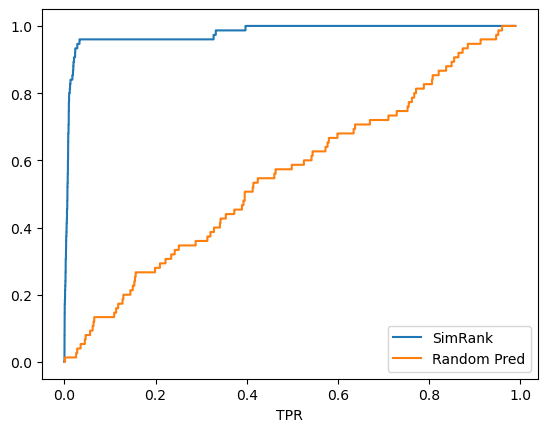

In [44]:
plt.plot(simrank_evaluation.fallout(), simrank_evaluation.recall(), label="SimRank")
plt.plot(rnd_evaluation.fallout(), rnd_evaluation.recall(), label="Random Pred")

plt.xlabel("FPR")
plt.xlabel("TPR")
plt.legend()
plt.show()

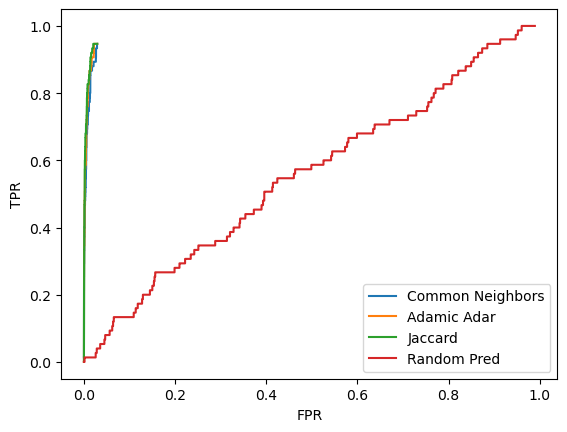

In [45]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")
plt.plot(rnd_evaluation.fallout(), rnd_evaluation.recall(), label="Random Pred")


plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [46]:
preds = list(nx.preferential_attachment(training,universe))
pref_results=[]
for u, v, p in preds:
    pref_results.append([u,v,p])
pref_results=sorted(pref_results,key=lambda x: x[2],reverse=True)
pref_results

[['SUGAMA SADAYUKI', 'IKEDA MASAMI', 3276],
 ['ISHINAGA HIROYUKI', 'IKEDA MASAMI', 2772],
 ['IKEDA MASAMI', 'ABE TSUTOMU', 2646],
 ['KASHINO TOSHIO', 'IKEDA MASAMI', 2646],
 ['SUGITANI HIROSHI', 'IKEDA MASAMI', 2646],
 ['KUWABARA NOBUYUKI', 'IKEDA MASAMI', 2583],
 ['IKEDA MASAMI', 'HIRABAYASHI HIROMITSU', 2457],
 ['KARITA SEIICHIRO', 'IKEDA MASAMI', 2394],
 ['SUGAMA SADAYUKI', 'ISHINAGA HIROYUKI', 2288],
 ['MASUDA KAZUAKI', 'IKEDA MASAMI', 2268],
 ['SUGAMA SADAYUKI', 'KASHINO TOSHIO', 2184],
 ['SUGAMA SADAYUKI', 'ABE TSUTOMU', 2184],
 ['SUGITANI HIROSHI', 'SUGAMA SADAYUKI', 2184],
 ['SUGIMOTO HITOSHI', 'IKEDA MASAMI', 2142],
 ['SUGAMA SADAYUKI', 'KUWABARA NOBUYUKI', 2132],
 ['ORIKASA TSUYOSHI', 'IKEDA MASAMI', 2079],
 ['IKEDA MASAMI', 'AKIYAMA YUJI', 2079],
 ['SUGAMA SADAYUKI', 'HIRABAYASHI HIROMITSU', 2028],
 ['SAIKAWA HIDEO', 'IKEDA MASAMI', 2016],
 ['TAJIKA HIROSHI', 'IKEDA MASAMI', 2016],
 ['SUGAMA SADAYUKI', 'KARITA SEIICHIRO', 1976],
 ['KOTAKI YASUO', 'IKEDA MASAMI', 1953],
 ['IZ

In [47]:
def intersect(result_1, result_2, dim, name):
    print(f"{name}")
    int_1_2=[]
    count=0
    for item_1 in result_1:
        for item_2 in result_2:
            if item_1[0]==item_2[0]:
                int_1_2.append(item_1[0])
                count+=1
    print(set(int_1_2))
    return int_1_2

In [48]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [49]:
aa_cn = intersect(aa_results, cn_results, 300, "AA vs CN")
aa_jc = intersect(aa_results, jc_results, 300, "AA vs JC")
aa_aa = intersect(aa_results, aa_results, 300, "AA vs AA")
aa_sm = intersect(aa_results, simrank_results, 300, "AA vs SM")

AA vs CN
{'TAKEUCHI TOSHIFUMI', 'YOSHINAGA KAZUO', 'SHOJI MAMORU', 'AZUHATA SHIGERU', 'MELTON PATRICK BENEDICT', 'NARAHARA TOSHIKAZU', 'CHAN DAVID SO KEUNG', 'NARAYANAN VIJAY', 'INUI TOSHIHARU', 'YOKONO ATARU', 'KURODA SHINICHI', 'KIM JAE-YOEL', 'STOIA LUCAS JOHN', 'LEE HAK-JU', 'NOBUE TOMOTAKA', 'SHIN CHEOLKYU', 'HAMILTON II RICK A', 'YONEMITSU JUN', 'SRIVASTAVA ALOK MANI', 'MINEMURA HIROYUKI', 'ZHANG HUA', 'COMANZO HOLLY ANN', 'KIM SUNG-JIN', 'MURAI KEIICHI', 'SATO MAKOTO', 'KUDO KIYOMITSU', 'NISHIKAWA AKIO', 'VAN LIESHOUT GERT-JAN', 'JUNG JUNG-SOO', 'MATSUDA HIROMU', 'LORRAINE PETER WILLIAM', 'MIYABE SHIGEO', 'VAN DER VELDE HIMKE', 'CHO JOON-YOUNG', 'MISUMI TERUO', 'KIM SANG-BUM', 'TANAKA SHIGEAKI', 'LIU YUNFENG', 'SUZUKI HIDETOSHI', 'MIYAMOTO HARUKAZU', 'LJUNG RICKARD', 'PARK DONG-SEEK', 'HSU LOUIS L', 'MONIZ THOMAS ORY', 'KING ROBERT DEAN', 'BAUGHMAN AARON K', 'TANAKA SHINICHI', 'ISOGAI TOKIO', 'KWATRA SHIKHAR', 'TAMURA YASUYUKI', 'HOFER DOUGLAS CARL', 'GREINER DAN F', 'CUI YAN', 

In [50]:
cn_jc = intersect(cn_results, jc_results, 300, "CN vs JC")
cn_aa = intersect(cn_results, aa_results, 300, "CN vs AA")
cn_sm = intersect(cn_results, simrank_results, 300, "CN vs SM")

CN vs JC
{'TAKEUCHI TOSHIFUMI', 'YOSHINAGA KAZUO', 'SHOJI MAMORU', 'AZUHATA SHIGERU', 'MELTON PATRICK BENEDICT', 'NARAHARA TOSHIKAZU', 'CHAN DAVID SO KEUNG', 'NARAYANAN VIJAY', 'INUI TOSHIHARU', 'YOKONO ATARU', 'KURODA SHINICHI', 'KIM JAE-YOEL', 'STOIA LUCAS JOHN', 'LEE HAK-JU', 'NOBUE TOMOTAKA', 'SHIN CHEOLKYU', 'HAMILTON II RICK A', 'YONEMITSU JUN', 'SRIVASTAVA ALOK MANI', 'MINEMURA HIROYUKI', 'ZHANG HUA', 'COMANZO HOLLY ANN', 'KIM SUNG-JIN', 'MURAI KEIICHI', 'SATO MAKOTO', 'KUDO KIYOMITSU', 'NISHIKAWA AKIO', 'VAN LIESHOUT GERT-JAN', 'JUNG JUNG-SOO', 'MATSUDA HIROMU', 'LORRAINE PETER WILLIAM', 'MIYABE SHIGEO', 'VAN DER VELDE HIMKE', 'CHO JOON-YOUNG', 'MISUMI TERUO', 'KIM SANG-BUM', 'TANAKA SHIGEAKI', 'LIU YUNFENG', 'SUZUKI HIDETOSHI', 'MIYAMOTO HARUKAZU', 'LJUNG RICKARD', 'PARK DONG-SEEK', 'HSU LOUIS L', 'MONIZ THOMAS ORY', 'KING ROBERT DEAN', 'BAUGHMAN AARON K', 'TANAKA SHINICHI', 'ISOGAI TOKIO', 'KWATRA SHIKHAR', 'TAMURA YASUYUKI', 'HOFER DOUGLAS CARL', 'GREINER DAN F', 'CUI YAN', 

In [51]:
jc_aa = intersect(jc_results, aa_results, 300, "JC vs AA")
jc_sm = intersect(jc_results, simrank_results, 300, "JC vs SM")

JC vs AA
{'TAKEUCHI TOSHIFUMI', 'YOSHINAGA KAZUO', 'SHOJI MAMORU', 'AZUHATA SHIGERU', 'MELTON PATRICK BENEDICT', 'NARAHARA TOSHIKAZU', 'CHAN DAVID SO KEUNG', 'NARAYANAN VIJAY', 'INUI TOSHIHARU', 'YOKONO ATARU', 'KURODA SHINICHI', 'KIM JAE-YOEL', 'STOIA LUCAS JOHN', 'LEE HAK-JU', 'NOBUE TOMOTAKA', 'SHIN CHEOLKYU', 'HAMILTON II RICK A', 'YONEMITSU JUN', 'SRIVASTAVA ALOK MANI', 'MINEMURA HIROYUKI', 'ZHANG HUA', 'COMANZO HOLLY ANN', 'KIM SUNG-JIN', 'MURAI KEIICHI', 'SATO MAKOTO', 'KUDO KIYOMITSU', 'NISHIKAWA AKIO', 'VAN LIESHOUT GERT-JAN', 'JUNG JUNG-SOO', 'MATSUDA HIROMU', 'LORRAINE PETER WILLIAM', 'MIYABE SHIGEO', 'VAN DER VELDE HIMKE', 'CHO JOON-YOUNG', 'MISUMI TERUO', 'KIM SANG-BUM', 'TANAKA SHIGEAKI', 'LIU YUNFENG', 'SUZUKI HIDETOSHI', 'MIYAMOTO HARUKAZU', 'LJUNG RICKARD', 'PARK DONG-SEEK', 'HSU LOUIS L', 'MONIZ THOMAS ORY', 'KING ROBERT DEAN', 'BAUGHMAN AARON K', 'TANAKA SHINICHI', 'ISOGAI TOKIO', 'KWATRA SHIKHAR', 'TAMURA YASUYUKI', 'HOFER DOUGLAS CARL', 'GREINER DAN F', 'CUI YAN', 

In [52]:
aa_sm = intersect(aa_results, simrank_results, 300, "AA vs SM")

AA vs SM
{'TAKEUCHI TOSHIFUMI', 'YOSHINAGA KAZUO', 'SHOJI MAMORU', 'AZUHATA SHIGERU', 'MELTON PATRICK BENEDICT', 'NARAHARA TOSHIKAZU', 'CHAN DAVID SO KEUNG', 'NARAYANAN VIJAY', 'INUI TOSHIHARU', 'YOKONO ATARU', 'KURODA SHINICHI', 'KIM JAE-YOEL', 'STOIA LUCAS JOHN', 'LEE HAK-JU', 'NOBUE TOMOTAKA', 'SHIN CHEOLKYU', 'HAMILTON II RICK A', 'YONEMITSU JUN', 'SRIVASTAVA ALOK MANI', 'MINEMURA HIROYUKI', 'ZHANG HUA', 'COMANZO HOLLY ANN', 'KIM SUNG-JIN', 'MURAI KEIICHI', 'SATO MAKOTO', 'KUDO KIYOMITSU', 'NISHIKAWA AKIO', 'VAN LIESHOUT GERT-JAN', 'JUNG JUNG-SOO', 'MATSUDA HIROMU', 'LORRAINE PETER WILLIAM', 'MIYABE SHIGEO', 'VAN DER VELDE HIMKE', 'CHO JOON-YOUNG', 'MISUMI TERUO', 'KIM SANG-BUM', 'TANAKA SHIGEAKI', 'LIU YUNFENG', 'SUZUKI HIDETOSHI', 'MIYAMOTO HARUKAZU', 'LJUNG RICKARD', 'PARK DONG-SEEK', 'HSU LOUIS L', 'MONIZ THOMAS ORY', 'KING ROBERT DEAN', 'BAUGHMAN AARON K', 'TANAKA SHINICHI', 'ISOGAI TOKIO', 'KWATRA SHIKHAR', 'TAMURA YASUYUKI', 'HOFER DOUGLAS CARL', 'GREINER DAN F', 'CUI YAN', 

In [53]:
# All intersection
int_m=intersection(cn_jc,aa_sm)
int_final=intersection(int_m,aa_sm)

In [54]:
len(int_final)

385411

In [55]:
set(int_final)

{'ANDO TAKASHI',
 'AOTA KINYA',
 'ARA YOJI',
 'ARAI ATSUSHI',
 'ARASHIMA TERUO',
 'ASUKAI MASAMICHI',
 'ATAGO TAKESHI',
 'AZUHATA SHIGERU',
 'BAE TAEHAN',
 'BASKER VEERARAGHAVAN S',
 'BAUGHMAN AARON K',
 'BEDELL STEPHEN W',
 'BEKKI TOSHIHIKO',
 'BOARDMAN GREGORY ALLEN',
 'BODEN EUGENE PAULING',
 'BOSS GREGORY J',
 'BRAY JAMES WILLIAM',
 'BREEZE-STRINGFELLOW ANDREW',
 'BUNKER RONALD SCOTT',
 'BURDGICK STEVEN SEBASTIAN',
 'CARTER WILLIAM THOMAS',
 'CELLA JAMES ANTHONY',
 'CHAN DAVID SO KEUNG',
 'CHAN KWOK PONG',
 'CHANG YOUNG-BIN',
 'CHEN WEI',
 'CHENG KANGGUO',
 'CHIDAMBARRAO DURESETI',
 'CHILA RONALD JAMES',
 'CHO JAE-WEON',
 'CHO JOON YOUNG',
 'CHO JOON-YOUNG',
 'CHOI BYEONG-DOO',
 'CHOI HO-KYU',
 'CHOI SEUNG-HOON',
 'CHOI SEUNGHOON',
 'CHOI SUNG-HO',
 'CLEMENTS JEFFREY DONALD',
 'CLEVENGER LAWRENCE A',
 'COLBURN MATTHEW E',
 'COMANZO HOLLY ANN',
 'COOPER JARED KLINEMAN',
 'CUI YAN',
 'DALTON TIMOTHY J',
 'DAROLIA RAMGOPAL',
 'DAUM WOLFGANG',
 'DAVIS GARY CHARLES',
 'DAVIS JR LEWIS BE

In [56]:
##Supervised approach*

In [95]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter
import random



all_edges = list(g.edges())

# Estrazione archi per il training
num_train_edges = int(len(all_edges) * 0.8)  
train_edges = random.sample(all_edges, num_train_edges)

test_edges = [edge for edge in all_edges if edge not in train_edges]

# Addestrare il modello Node2Vec sul grafo completo
embedding_size = 128
node2vec = Node2Vec(g, dimensions=embedding_size)
model = node2vec.fit()

# Rappresentazioni vettoriali per gli archi di addestramento
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
train_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in train_edges]

# Rappresentazioni vettoriali per gli archi di test
test_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in test_edges]




Computing transition probabilities:   0%|          | 0/13237 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.75s/it]


In [89]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,6172,Train Graph,Test Graph,Train the Link Classifier
Model Selection,2058,Train Graph,Test Graph,Select the best Link Classifier model
Test set,9144,Test Graph,Full Graph,Evaluate the best Link Classifier


In [69]:
!pip install node2vec==0.4.

  Using cached node2vec-0.4.0-py3-none-any.whl
  Attempting uninstall: node2vec
    Found existing installation: node2vec 0.4.6
    Uninstalling node2vec-0.4.6:
      Successfully uninstalled node2vec-0.4.6


In [60]:
!pip install --upgrade node2vec stellargraph

  Using cached node2vec-0.4.6-py3-none-any.whl (7.0 kB)
  Using cached networkx-2.8.8-py3-none-any.whl (2.0 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4
  Attempting uninstall: node2vec
    Found existing installation: node2vec 0.4.0
    Uninstalling node2vec-0.4.0:
      Successfully uninstalled node2vec-0.4.0


In [61]:
!pip install node2vec


In [96]:
len(train_embeddings)

36577

In [97]:
len(test_embeddings)

9145

In [72]:
##Random Forest

In [99]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [100]:
clf = RandomForestClassifier(random_state = 42)

In [101]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier()  

num_samples = min(len(train_embeddings), len(labels_train))
train_embeddings = train_embeddings[:num_samples]
labels_train = labels_train[:num_samples]


param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy')
grid_search.fit(train_embeddings, labels_train)

print("Best parameters: ", grid_search.best_params_)


C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Alma\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_param

Best parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}


In [104]:
res = grid_search.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.517 (std: 0.018)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.512 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.512 (std: 0.009)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}



In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

min_samples = min(len(train_embeddings), len(labels_train))
train_embeddings = train_embeddings[:min_samples]
labels_train = labels_train[:min_samples]

min_samples = min(len(test_embeddings), len(labels_test))
test_embeddings = test_embeddings[:min_samples]
labels_test = labels_test[:min_samples]

rf = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=20)
rf.fit(train_embeddings, labels_train)

y_pred = rf.predict(test_embeddings)
print('Accuracy:', metrics.accuracy_score(labels_test, y_pred))
print('Precision:', metrics.precision_score(labels_test, y_pred))
print('Recall:', metrics.recall_score(labels_test, y_pred))
print('F1-Score:', metrics.f1_score(labels_test, y_pred))


Accuracy: 0.48720472440944884
Precision: 0.4870718232044199
Recall: 0.4820647419072616
F1-Score: 0.48455534791689575


In [108]:
print( classification_report(labels_test, y_pred) )

              precision    recall  f1-score   support

           0       0.49      0.49      0.49      4572
           1       0.49      0.48      0.48      4572

    accuracy                           0.49      9144
   macro avg       0.49      0.49      0.49      9144
weighted avg       0.49      0.49      0.49      9144



In [109]:
y_score = rf.predict_proba(test_embeddings)

In [110]:
fpr, tpr, th = roc_curve(labels_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

0.489117830087512


In [111]:
##Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegressionCV

In [115]:
lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy")
lr_clf.fit(train_embeddings, labels_train); 

In [116]:
y_pred_lr = lr_clf.predict(test_embeddings) 
print('Accuracy', metrics.accuracy_score(labels_test, y_pred_lr)) 
print('Precision:', metrics.precision_score(labels_test, y_pred_lr)) 
print('Recall:', metrics.recall_score(labels_test, y_pred_lr)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred_lr))  

Accuracy 0.5080927384076991
Precision: 0.5082405345211581
Recall: 0.4991251093613298
F1-Score: 0.503641580225116


In [117]:
print(classification_report(labels_test, y_pred_lr) )

              precision    recall  f1-score   support

           0       0.51      0.52      0.51      4572
           1       0.51      0.50      0.50      4572

    accuracy                           0.51      9144
   macro avg       0.51      0.51      0.51      9144
weighted avg       0.51      0.51      0.51      9144



In [118]:
y_score_lr = lr_clf.predict_proba(test_embeddings)
fpr_lg, tpr_lg, th_lg = roc_curve(labels_test, y_score_lr[:,1])

roc_auc = auc(fpr_lg, tpr_lg)

In [119]:
##SVM

In [120]:
from sklearn.svm import SVC

In [121]:
param_grid = { 'C':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid = GridSearchCV(SVC(),param_grid)
grid.fit(train_embeddings, labels_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [122]:
res = grid.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.513 (std: 0.011)
Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.512 (std: 0.007)
Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.512 (std: 0.004)
Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}



In [123]:
svm = SVC(C = 100, kernel = "rbf", gamma = 1, probability = True) 
svm.fit(train_embeddings, labels_train); 
 
y_pred_svm = svm.predict(test_embeddings) 
print('Accuracy', metrics.accuracy_score(labels_test, y_pred_svm)) 
print('Precision:', metrics.precision_score(labels_test, y_pred_svm)) 
print('Recall:', metrics.recall_score(labels_test, y_pred_svm)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred_svm)) 


Accuracy 0.5068897637795275
Precision: 0.5069736550808058
Recall: 0.5008748906386702
F1-Score: 0.5039058202222467


In [124]:
print(classification_report(labels_test, y_pred_svm) )

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      4572
           1       0.51      0.50      0.50      4572

    accuracy                           0.51      9144
   macro avg       0.51      0.51      0.51      9144
weighted avg       0.51      0.51      0.51      9144



In [125]:
y_score_svm = svm.predict_proba(test_embeddings)
fpr_svm, tpr_svm, th_svm = roc_curve(labels_test, y_score_svm[:,1])

roc_auc = auc(fpr_svm, tpr_svm)
print(roc_auc)

0.49447553061772787


In [126]:
##ROC curve comparison

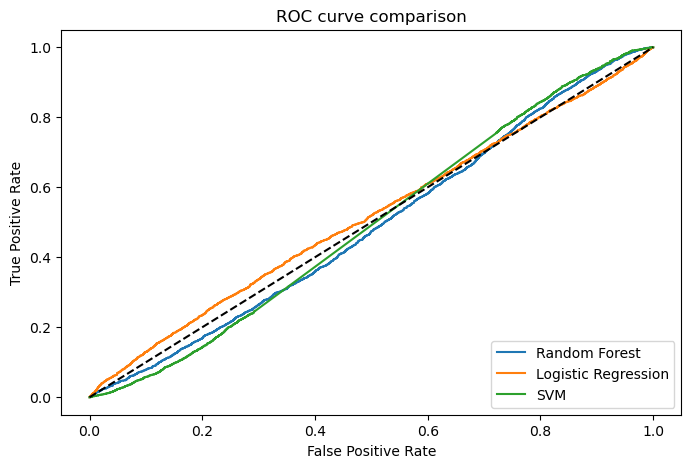

In [127]:
plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label ="Random Forest")
plt.plot(fpr_lg, tpr_lg, label = "Logistic Regression")
plt.plot(fpr_svm, tpr_svm, label = "SVM")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize = 10)
plt.title("ROC curve comparison")
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "lower right")
plt.show()